In [59]:
import cv2
import numpy as np
import os
import pandas as pd
import csv
import matplotlib.pyplot as plt


from sklearn.cluster import MiniBatchKMeans
from sklearn.neural_network import MLPClassifier
from progressbar import ProgressBar
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from matplotlib import cm
from sklearn import datasets
from sklearn.manifold import TSNE


In [3]:
sift = cv2.SIFT_create()

In [4]:
img_path = '../TargetImages/'
train = pd.read_csv('TargetData-TF-Train.csv')
landmarks = train['landmark_id'].sort_values().unique()

dico = []


for leaf in train.id:
    img = cv2.imread(img_path + str(leaf) + ".jpg")
    kp, des = sift.detectAndCompute(img, None)

    for d in des:
        dico.append(d)

##### Length of the initial sift is 128

In [5]:
len(dico[0])

128

In [6]:

k = np.size(landmarks) * 10

batch_size = np.size(os.listdir(img_path)) * 3
kmeans = MiniBatchKMeans(n_clusters=k, batch_size=batch_size, verbose=1).fit(dico)

Init 1/3 with method k-means++
Inertia for init 1/3: 54579455568.0
Init 2/3 with method k-means++
Inertia for init 2/3: 54702330020.0
Init 3/3 with method k-means++
Inertia for init 3/3: 55365268620.0
Minibatch step 1/398: mean batch inertia: 133003.3440107652
Minibatch step 2/398: mean batch inertia: 90286.31346503453, ewa inertia: 90286.31346503453
Minibatch step 3/398: mean batch inertia: 89031.52498102108, ewa inertia: 89655.78820029984
Minibatch step 4/398: mean batch inertia: 88727.52244961585, ewa inertia: 89189.33906114125
Minibatch step 5/398: mean batch inertia: 88293.68755455542, ewa inertia: 88739.27842503009
Minibatch step 6/398: mean batch inertia: 88165.69625792475, ewa inertia: 88451.0561051978
Minibatch step 7/398: mean batch inertia: 88076.0330802753, ewa inertia: 88262.6088130179
Minibatch step 8/398: mean batch inertia: 87937.12751070413, ewa inertia: 88099.05600159013
Minibatch step 9/398: mean batch inertia: 87868.02125055065, ewa inertia: 87982.96213444197
Miniba

In [7]:

kmeans.verbose = False

histo_list = []
pbar = ProgressBar()
for leaf in pbar(train.id):
    img = cv2.imread(img_path + str(leaf) + ".jpg")
    kp, des = sift.detectAndCompute(img, None)

    histo = np.zeros(k)
    nkp = np.size(kp)

    for d in des:
        idx = kmeans.predict([d])
        histo[idx] += 1/nkp # Because we need normalized histograms, I prefere to add 1/nkp directly

    histo_list.append(histo)

100% |########################################################################|


In [21]:
histo_list[0]
np.sum(histo_list[0])

0.9999999999999988

In [9]:
X = np.array(histo_list)
Y = np.array(train['landmark_id'])

In [10]:
mlp = MLPClassifier(verbose=True, max_iter=600000)
mlp.fit(X, Y)

Iteration 1, loss = 1.63084208
Iteration 2, loss = 1.62778443
Iteration 3, loss = 1.62511204
Iteration 4, loss = 1.62256607
Iteration 5, loss = 1.62037989
Iteration 6, loss = 1.61826690
Iteration 7, loss = 1.61622438
Iteration 8, loss = 1.61518343
Iteration 9, loss = 1.61332546
Iteration 10, loss = 1.61192373
Iteration 11, loss = 1.61087346
Iteration 12, loss = 1.60950921
Iteration 13, loss = 1.60870093
Iteration 14, loss = 1.60796262
Iteration 15, loss = 1.60683481
Iteration 16, loss = 1.60593015
Iteration 17, loss = 1.60515019
Iteration 18, loss = 1.60449599
Iteration 19, loss = 1.60369423
Iteration 20, loss = 1.60303445
Iteration 21, loss = 1.60223761
Iteration 22, loss = 1.60157164
Iteration 23, loss = 1.60085724
Iteration 24, loss = 1.60023672
Iteration 25, loss = 1.59950786
Iteration 26, loss = 1.59876383
Iteration 27, loss = 1.59804895
Iteration 28, loss = 1.59740239
Iteration 29, loss = 1.59672723
Iteration 30, loss = 1.59603254
Iteration 31, loss = 1.59522981
Iteration 32, los

MLPClassifier(max_iter=600000, verbose=True)

In [11]:
test = pd.read_csv('TargetData-TF-Test.csv')

result_file = open("sift.csv", "w")
result_file_obj = csv.writer(result_file)
result_file_obj.writerow(np.append("id", landmarks))
pbars = ProgressBar()
predictionsarr = []

for leaf in pbars(test.id):
    img = cv2.imread(img_path + str(leaf) + ".jpg")
    kp, des = sift.detectAndCompute(img, None)

    x = np.zeros(k)
    nkp = np.size(kp)

    for d in des:
        idx = kmeans.predict([d])
        x[idx] += 1/nkp

    res = mlp.predict_proba([x])
    row = []
    row.append(leaf)
    predictionsarr.append(mlp.predict([x]))
    for e in res[0]:
        row.append(e)

    result_file_obj.writerow(row)

result_file.close()

100% |########################################################################|


### Get the Predictions

In [12]:
predictions = np.array(predictionsarr)

finpreds = []
for i in range(len(predictions)):
    finpreds.append(predictions[i][0])

In [13]:
labels_test = np.array(test['landmark_id'])
accuracy = accuracy_score(finpreds, labels_test)

In [14]:
accuracy

0.64

In [57]:

confusion_matrix(labels_test, finpreds)

array([[15,  2,  3,  3,  2],
       [ 0, 17,  5,  1,  2],
       [ 1,  3, 16,  2,  3],
       [ 0,  2,  1, 17,  5],
       [ 2,  1,  4,  3, 15]])

### Example of an incorrectly clasified object

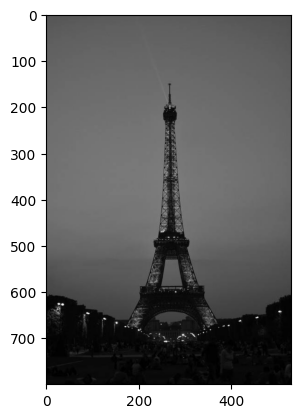

In [24]:
im = cv2.imread('../TargetImages/201edb4a52549725.jpg', 0)
training_image = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
imgplot = plt.imshow(training_image, cmap='gray')


## Visual Look at the SIFT Features

### Histogram Representation

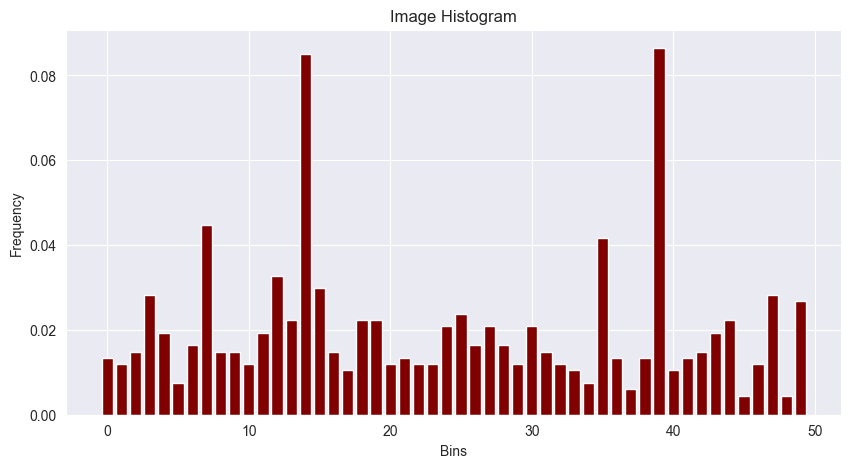

In [51]:
# Create our freq and bins from the vector coming out of the histogram generation
freq = histo_list[1]
bins = [i for i in range(len(freq))]

fig = plt.figure(figsize = (10, 5))
# creating the bar plot
plt.bar(bins, freq, color ='maroon')
plt.xlabel("Bins")
plt.ylabel("Frequency")
plt.title("Image Histogram")
plt.show()

### SIFT Features Key Points

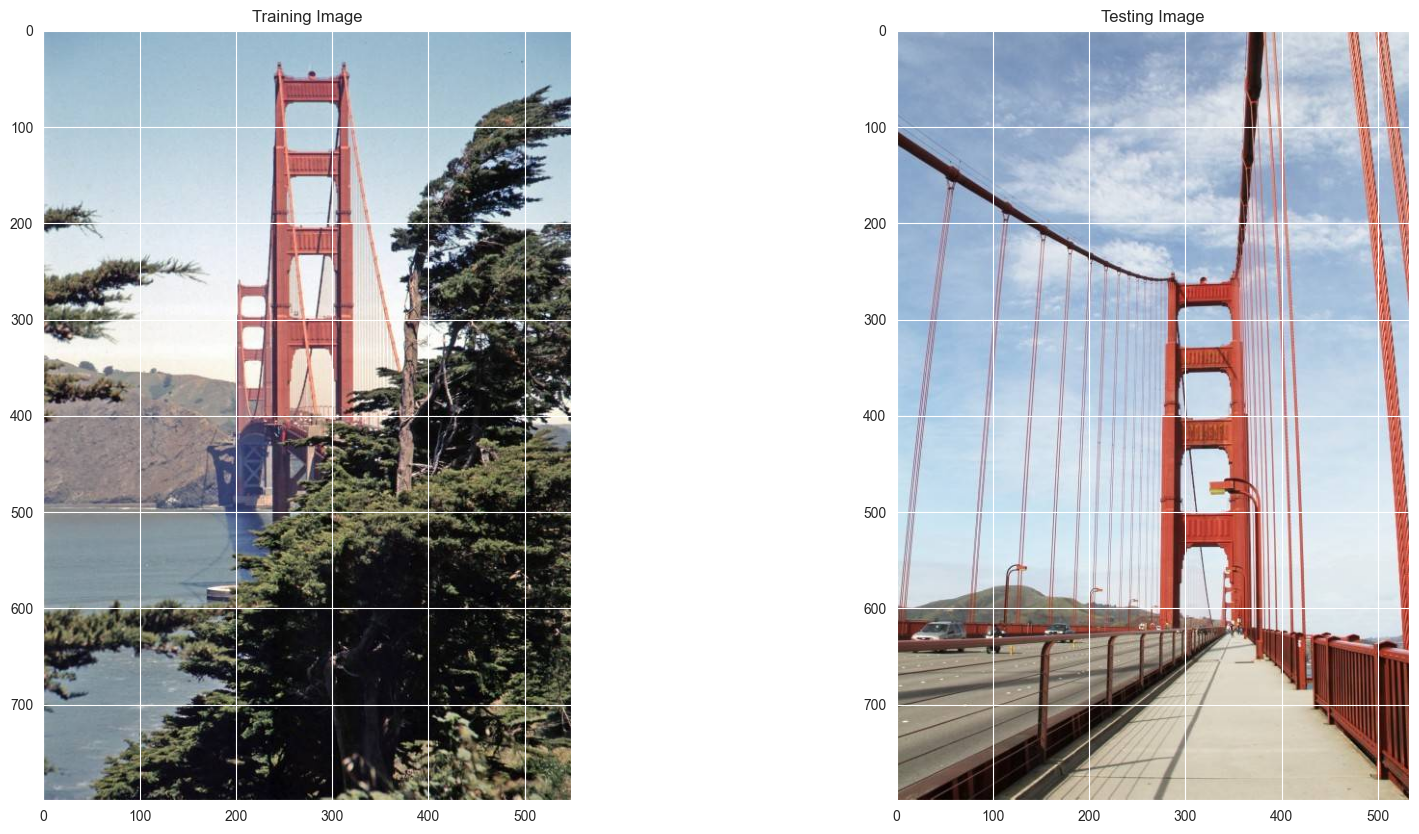

In [53]:


im1 = cv2.imread('../TargetImages/937bc82bcbd48c06.jpg')

im2 = cv2.imread('../TargetImages/edf37773bfa2d899.jpg')

# Convert the training image to RGB
training_image = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)

# Convert the training image to gray scale
training_gray = cv2.cvtColor(training_image, cv2.COLOR_RGB2GRAY)

# Convert the training image to RGB
testing_image = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)

# Convert the training image to gray scale
testing_gray = cv2.cvtColor(testing_image, cv2.COLOR_RGB2GRAY)

# # Create test image by adding Scale Invariance and Rotational Invariance
# test_image = cv2.pyrDown(training_image)
# test_image = cv2.pyrDown(test_image)
# num_rows, num_cols = test_image.shape[:2]

# rotation_matrix = cv2.getRotationMatrix2D((num_cols/2, num_rows/2), 30, 1)
# test_image = cv2.warpAffine(test_image, rotation_matrix, (num_cols, num_rows))

# test_gray = cv2.cvtColor(test_image, cv2.COLOR_RGB2GRAY)

# Display traning image and testing image
fx, plots = plt.subplots(1, 2, figsize=(20,10))

plots[0].set_title("Training Image")
plots[0].imshow(training_image)

plots[1].set_title("Testing Image")
plots[1].imshow(testing_image)


Number of Keypoints Detected In The Training Image:  4991
Number of Keypoints Detected In The Query Image:  1352


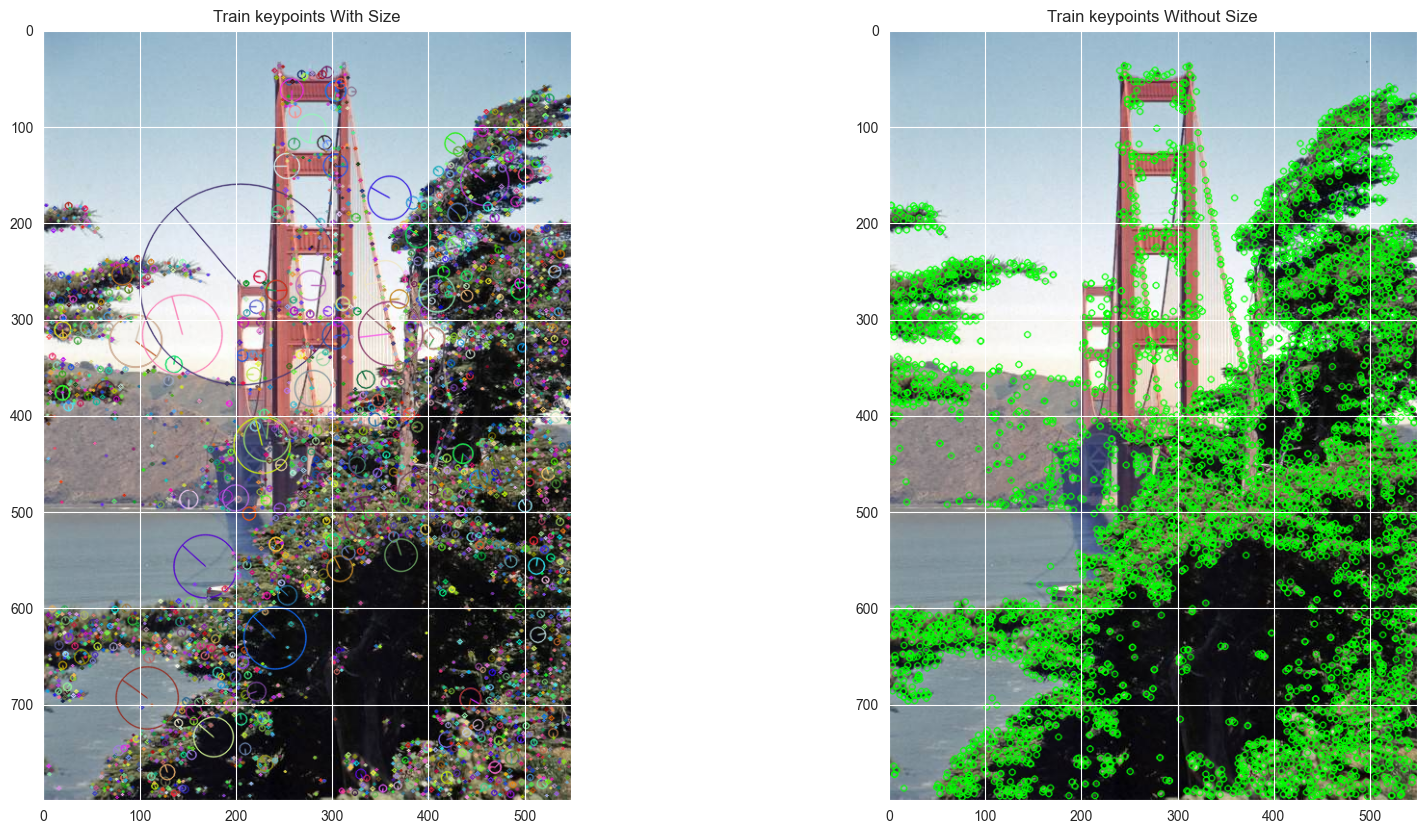

In [54]:
sift = cv2.SIFT_create()

train_keypoints, train_descriptor = sift.detectAndCompute(training_gray, None)
test_keypoints, test_descriptor = sift.detectAndCompute(testing_gray, None)

keypoints_without_size = np.copy(training_image)
keypoints_with_size = np.copy(training_image)

cv2.drawKeypoints(training_image, train_keypoints, keypoints_without_size, color = (0, 255, 0))

cv2.drawKeypoints(training_image, train_keypoints, keypoints_with_size, flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display image with and without keypoints size
fx, plots = plt.subplots(1, 2, figsize=(20,10))

plots[0].set_title("Train keypoints With Size")
plots[0].imshow(keypoints_with_size, cmap='gray')

plots[1].set_title("Train keypoints Without Size")
plots[1].imshow(keypoints_without_size, cmap='gray')

# Print the number of keypoints detected in the training image
print("Number of Keypoints Detected In The Training Image: ", len(train_keypoints))

# Print the number of keypoints detected in the query image
print("Number of Keypoints Detected In The Query Image: ", len(test_keypoints))

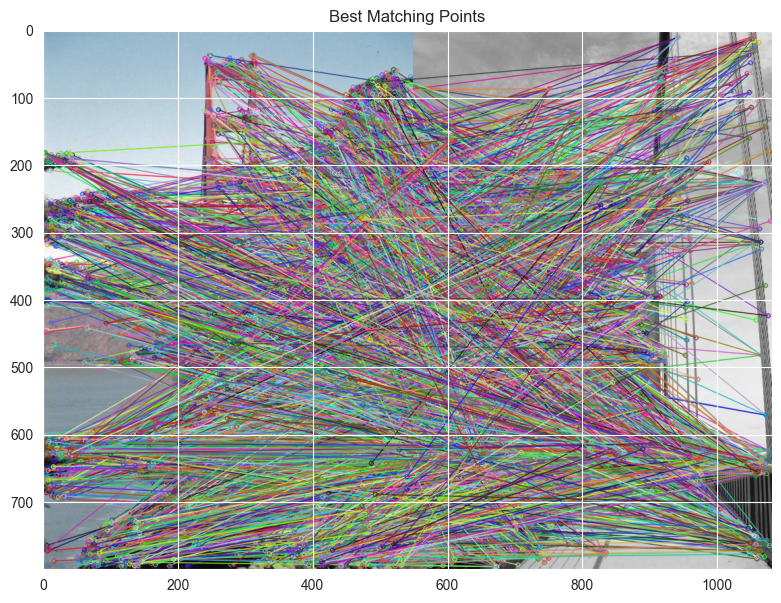


Number of Matching Keypoints Between The Training and Query Images:  4991


In [56]:
# Create a Brute Force Matcher object.
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck = False)

# Perform the matching between the SIFT descriptors of the training image and the test image
matches = bf.match(train_descriptor, test_descriptor)

# The matches with shorter distance are the ones we want.
matches = sorted(matches, key = lambda x : x.distance)

result = cv2.drawMatches(training_image, train_keypoints, testing_gray, test_keypoints, matches, testing_gray, flags = 2)

# Display the best matching points
plt.rcParams['figure.figsize'] = [14.0, 7.0]
plt.title('Best Matching Points')
plt.imshow(result)
plt.show()

# Print total number of matching points between the training and query images
print("\nNumber of Matching Keypoints Between The Training and Query Images: ", len(matches))

### TSNE Visualization of the histogram Features

In [125]:
tsne = TSNE(n_components=2, random_state=0)
TX = tsne.fit_transform(X)
Ty = np.unique(Y)

/Users/vtanna/.pyenv/versions/3.10.8/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/vtanna/.pyenv/versions/3.10.8/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [126]:
Ty

array([  1924,  10419,  47378, 162833, 168098])

In [127]:
plt.figure(figsize=(10,10))

viridis = cm.get_cmap('viridis')
colors = np.linspace(0,1,5)

<Figure size 1000x1000 with 0 Axes>

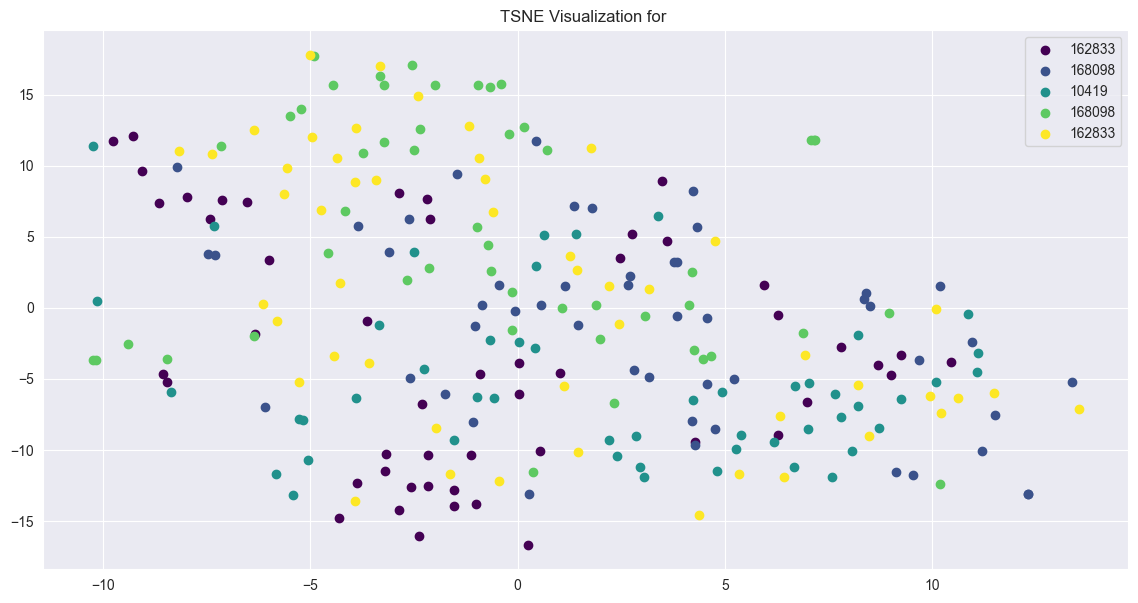

In [128]:
for i,c,l in zip(Ty, colors, Y):
    plt.scatter (
        TX[Y==i,0],
        TX[Y==i,1],
        color=viridis(c),
        label=l,
    )
plt.title('TSNE Visualization for ')
plt.legend()
plt.show()